## Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, io, sys, pdb
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from tqdm import tqdm
from PIL import Image
import kornia.augmentation as K
import matplotlib.pyplot as plt

sys.path.append("3_attack")
from utils.unet import UNetModel
from utils.diffusion import GaussianDiffusion
from utils.utils import *
from models.classifier import VGG16, IR152, FaceNet64, FaceNet

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device('cuda')
set_random_seed(0)

## Load Models

In [2]:
public_dataset = "celeba"  # celeba, ffhq, facescrub
target_classifier = "VGG16"  # FaceNet64, IR152, VGG16
CDM_path = "{Path of target-specific CDM}"

# Load target-specific CDM
diff_net = UNetModel(
        image_size=64,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=3,
        attention_resolutions=(4,8),
        dropout=0.0,
        channel_mult=(1, 2, 3, 4),
        num_classes=1001,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=4,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
    ).to(device)
diff_net.load_state_dict(torch.load(CDM_path))
diff_net.eval()
print('1. Loaded Diffusion Model')

# Load target classifier
if target_classifier == "VGG16":
    T = VGG16(1000)
    path_T = 'assets/checkpoints/target_model/VGG16_88.26.tar'
elif target_classifier == 'IR152':
    T = IR152(1000)
    path_T = 'assets/checkpoints/target_model/IR152_91.16.tar'
elif target_classifier == "FaceNet64":
    T = FaceNet64(1000)
    path_T = 'assets/checkpoints/target_model/FaceNet64_88.50.tar'
T = torch.nn.DataParallel(T).to(device)
ckp_T = torch.load(path_T)
T.load_state_dict(ckp_T['state_dict'])
print('2. Loaded Target Classifier')

# Load public features for p_reg
p_reg = torch.load(f"data/p_reg/{public_dataset}_{target_classifier}_p_reg.pt")

1. Loaded Diffusion Model
2. Loaded Target Classifier


## Preparation

In [3]:
class InferenceModel(nn.Module):
    def __init__(self, x=None, batch_size=16):
        super(InferenceModel, self).__init__()
        if x is None:
            self.img = nn.Parameter(torch.randn(batch_size, 3, 64, 64))
        else:
            self.img = nn.Parameter(x)
        self.img.requires_grad = True
    def encode(self):
        return self.img

aug = K.container.ImageSequential(
        K.RandomHorizontalFlip(),
        K.ColorJitter(brightness=0.2, p=0.5),
        K.RandomGaussianBlur((7, 7), (3, 3), p=0.5),
    )

def topk_loss(out, iden, k):
    iden = iden.unsqueeze(1)
    real = out.gather(1, iden).squeeze(1)
    if k == 0: return -1 * real.mean()
    tmp_out = torch.scatter(out, dim=1, index=iden, src=-torch.ones_like(iden)*1000.0)
    margin = torch.topk(tmp_out, k=k)[0]
    return -1 * real.mean() + margin.mean()

def p_reg_loss(featureT, classes, p_reg):
    fea_reg = p_reg[classes]
    assert featureT.shape == fea_reg.shape
    return F.mse_loss(featureT, fea_reg)

def visualize(img, label):
    sample = ((img + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    arr = np.array([i.permute(1, 2, 0).cpu().numpy() for i in sample])
    N = min(int(np.sqrt(len(arr))), 4)

    fig, axes = plt.subplots(N, N, figsize=(4, 4))
    plt.subplots_adjust(wspace=0, hspace=0.5)

    for i in range(N * N):
        plt.subplot(N, N, i + 1)
        plt.imshow(arr[i])
        plt.title(label[i].item())
        plt.axis('off')

    # Save the Matplotlib figure to a BytesIO object
    img_bytes = io.BytesIO()
    plt.savefig(img_bytes, format='png', bbox_inches='tight', pad_inches=0)
    plt.close()

    # Convert the BytesIO object to a PIL Image
    img_pil = Image.open(img_bytes)

    return img_pil

def show_images_side_by_side(image1, image2, title1='Reconstructed Images (Diff-MI)', title2='Private Images (Ground-Truth)'):
    """
    Display two PIL images side by side in a Jupyter Notebook.

    Parameters:
    - image1: PIL image object for the first image
    - image2: PIL image object for the second image
    - title1: Title for the first image (default is 'Image 1')
    - title2: Title for the second image (default is 'Image 2')
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].set_title(title2)

    for ax in axes:
        ax.axis('off')

    plt.show()

## Specify Target Classes

In [7]:
start_id = 0
bs = 16

# classes = torch.tensor(np.arange(start_id, start_id + bs)).to(device)
classes = torch.randint(low=0, high=300, size=(bs,), device=device)
print('Target classes:', classes.tolist())

Target classes: [3, 34, 181, 157, 172, 68, 115, 68, 290, 68, 242, 146, 290, 234, 255, 150]


## Run Inference (Attack)

In [8]:

diffusion = GaussianDiffusion(T=1000, schedule='linear')
model = InferenceModel(batch_size=bs).to(device)
model.train()

# Inference procedure steps
steps, w , aug_times, ddim_step = 30, 3.0, 2, 100
norm_track = 0
opt = torch.optim.Adamax(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1.0, end_factor=1.0, total_iters=steps)

bar = tqdm(range(steps))
for i, _ in enumerate(bar): 

    # Select t
    t = ((steps-i)/1.5 + (steps-i)/3*math.cos(3/(10*math.pi)*i))/steps*800 + 200 # Linearly decreasing + cosine
    t = np.array([t + np.random.randint(-50, 51) for _ in range(1)]).astype(int) # Add noise to t
    t = np.clip(t, 1, diffusion.T)

    # Denoise
    sample_img = model.encode()
    xt, epsilon = diffusion.sample(sample_img, t)
    t = torch.from_numpy(t).float().view(1)
    eps = diff_net(xt.float(), t.to(device), classes)
    nonEps = diff_net(xt.float(), t.to(device), torch.ones_like(classes) * (diff_net.num_classes - 1))
    epsilon_pred = w * eps - (w - 1) * nonEps

    # Compute diffusion loss: ||epsilon - epsilon_theta||^2
    loss = 1 * F.mse_loss(epsilon_pred, epsilon)

    opt.zero_grad()
    loss.backward()

    with torch.no_grad():
        grad_norm = torch.linalg.norm(model.img.grad)
        if i > 0:
            alpha = 0.5
            norm_track = alpha*norm_track + (1-alpha)*grad_norm
        else:
            norm_track = grad_norm
    opt.step()

    attr_input_batch = []
    for _ in range(aug_times):
        attr_input = model.encode()
        attr_input = aug(attr_input).clamp(-1,1)
        attr_input_batch.append(attr_input)

    attr_input_batch = torch.cat(attr_input_batch, dim=0)
    feats, logits = T.forward((attr_input_batch+1)/2)

    # topk loss
    loss = topk_loss(logits, classes.repeat(aug_times), k=20) + \
           1.0 * p_reg_loss(feats, classes.repeat(aug_times), p_reg)

    opt.zero_grad()
    loss.backward()

    # Clip attribute loss gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.25 * norm_track)
    opt.step()
    scheduler.step()

with torch.no_grad():
    t = np.array([ddim_step]).astype(int)
    xt, _ = diffusion.sample(model.encode(), t)
    fine_tuned = diffusion.inverse_ddim(diff_net, x=xt, start_t=t[0], w=w, y=classes, device=device).clamp(-1,1)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


## Visualization

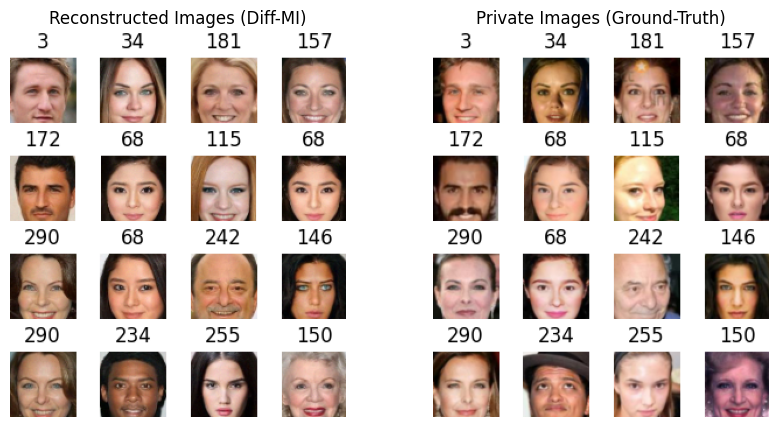

In [9]:
img_real = []
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

for idx in classes:
    class_path = os.path.join(PRIVATE_PATH, str(idx.item()))
    private_img_path = f"{class_path}/{random.choice(os.listdir(class_path))}"
    private_img = transform(Image.open(private_img_path))
    img_real.append(private_img)
img_real = torch.stack(img_real)

fig_real = visualize(img_real, classes)
fig_fake = visualize(fine_tuned, classes)
show_images_side_by_side(fig_fake, fig_real)